<a href="https://colab.research.google.com/github/abbyambita/Diagnosing-COVID-from-CT-Scan-Images/blob/main/transfer_learning_with_sagan_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os 

os.chdir("/content/gdrive/My Drive")

!ls  '/content/gdrive/My Drive/CS 284 Mini-Project/Code'

%cd "/content/gdrive/My Drive/CS 284 Mini-Project/Code"

 ACGAN.ipynb		       new_sars_cov
 acgan_output_images	       output_result
 BAGAN.ipynb		       plots
 bagan_output_images	       revised-git
 build_datasets.ipynb	       revised-kaggle-validation
 build_datasets_v2.ipynb       runs
 build_datasets_v3.ipynb       sagan_output_images
 COVID-CT-master	      'synthetic images'
 DCGAN.ipynb		       training-from-scratch-git.ipynb
 ECN_git.ipynb		       transfer_learning_models_git.ipynb
 ECN_git_with_acgan.ipynb      transfer_learning_models_kaggle.ipynb
 ECN_git_with_bagan.ipynb      transfer_learning_with_acgan_git.ipynb
 ECN_kaggle.ipynb	       transfer_learning_with_acgan_kaggle.ipynb
 ECN_kaggle_with_acgan.ipynb   transfer_learning_with_bagan_git.ipynb
 ECN_kaggle_with_bagan.ipynb   transfer_learning_with_bagan_kaggle.ipynb
 EN_git.ipynb		       transfer_learning_with_sagan_git.ipynb
 EN_git_with_acgan.ipynb       transfer_learning_with_sagan_kaggle.ipynb
 EN_git_with_bagan.ipynb       trial_acgan_git.ipynb
 EN_kaggle.ipynb	       tr

In [3]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

plt.ion()

In [4]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is available!  Training on GPU ...


In [6]:
from sklearn.model_selection import train_test_split

import collections

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((224, 224)),   
                                 transforms.CenterCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}

data_dir = 'revised-kaggle-validation'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
print(len(image_datasets['train']))
#load synthetic data
sagan_synthetic_dataset = datasets.ImageFolder(root='sagan_output_images/kaggle/batch_size=64,epoch=200',transform = data_transforms['train'])

#print(len(image_datasets['train']))

indices = np.arange(len(sagan_synthetic_dataset))
train_indices, test_indices = train_test_split(indices, train_size=1000*2, stratify=sagan_synthetic_dataset.targets)
train_dataset = torch.utils.data.Subset(sagan_synthetic_dataset, train_indices)
#train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=32)
print(len(train_dataset))
dataset = torch.utils.data.ConcatDataset([image_datasets['train'], train_dataset])

dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True, num_workers=4)
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True, num_workers=4)

dataset_sizes = {
    'train':len(dataset),
    'val': len(image_datasets['val']),
    'test': len(image_datasets['test'])
}
class_names = image_datasets['train'].classes

3021
2000


In [8]:
print(dataset_sizes)
print(class_names)

{'train': 5021, 'val': 365, 'test': 785}
['covid', 'noncovid']


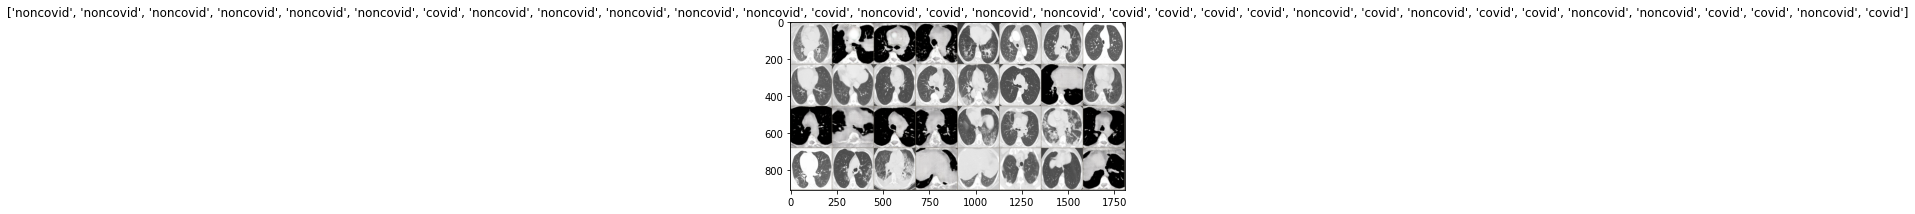

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
#remove scheduler

#def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
def train_model(model, criterion, optimizer, num_epochs=3):

    "Training begins..."


    train_losses = []
    test_losses = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_losses.append(epoch_loss)
            else:
              test_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def evaluate_performance(labels, preds, name, num_epochs):
  label = ['noncovid', 'covid']
  #print(confusion_matrix)
  conf_matrix = confusion_matrix(labels, preds)
  print(conf_matrix)

  # Per-class accuracy
  class_accuracy=100*conf_matrix.diagonal()/conf_matrix.sum(1)
  print(class_accuracy)

  print("Accuracy score:", accuracy_score(labels, preds))
  print(classification_report(labels, preds))

  report = classification_report(labels, preds, output_dict = True)
  df = pd.DataFrame(report).transpose()
  df.to_csv('model_result/sagan/kaggle/'+name+'_epochs_'+str(num_epochs)+'_classification_report.csv', index = False)


  plt.figure()
  plot_confusion_matrix(conf_matrix, classes=['NonCovid', 'Covid'],
                      title='Confusion matrix')
  plt.savefig('plots/sagan/kaggle/'+name+'_epochs_'+str(num_epochs)+'.png')
  plt.show()

In [11]:
# Do validation on the test set
def test(model, dataloaders, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

In [12]:
# Do validation on the test set (from another dataset)
def test_on_another_data(model, test_data, device, name, num_epochs):

  "Testing begins..."
  model.eval()
  accuracy = 0
  
  model.to(device)
  
  nb_classes = 2

  #confusion_matrix = torch.zeros(nb_classes, nb_classes)
  predlist = torch.zeros(0, dtype = torch.long, device = 'cpu')
  labellist = torch.zeros(0, dtype = torch.long, device = 'cpu')


  for images, labels in test_data:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    _, preds = torch.max(output, 1)
    # for t, p in zip(labels.view(-1), preds.view(-1)):
    #   confusion_matrix[t.long(), p.long()] += 1
    predlist=torch.cat([predlist,preds.view(-1).cpu()])
    labellist = torch.cat([labellist, labels.view(-1).cpu()])

    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

  evaluate_performance(labellist.numpy(), predlist.numpy(), name, num_epochs)

<h1>Models</h1>

In [13]:
from collections import OrderedDict


# classifier = nn.Sequential(OrderedDict([
#     ('fcl1', nn.Linear(1024,256)),
#     ('dp1', nn.Dropout(0.3)),
#     ('r1', nn.ReLU()),
#     ('fcl2', nn.Linear(256,32)),
#     ('dp2', nn.Dropout(0.3)),
#     ('r2', nn.ReLU()),
#     ('fcl3', nn.Linear(32,2)),
#     #('out', nn.LogSoftmax(dim=1)),
# ]))

In [14]:
train_losses_all = []
test_losses_all = []

In [15]:
def run_model(model, name, freeze = False):
  # Freeze parameters so we don't backprop through them
  for param in model.parameters():
    param.requires_grad = freeze

  #model.classifier = classifier


  if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()
    
  # NLLLoss because our output is LogSoftmax
  #criterion = nn.NLLLoss()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  num_epochs = 50

  model_ft, train_losses, test_losses = train_model(model, criterion, optimizer, num_epochs=num_epochs)
  train_losses_all.append(train_losses)
  test_losses_all.append(test_losses)
  #changed model -> model_ft, if something goes wrong change it back :P
  torch.save(model_ft, "model_backup/sagan/kaggle/"+name+"_epoch_"+str(num_epochs)+".pth")

  test(model_ft, dataloaders, device, name, num_epochs)

  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Validation Loss')
  plt.legend(frameon=False)

  plt.savefig("plots/sagan/kaggle/"+name+"_epoch_"+str(num_epochs)+"_losses.png")


In [16]:
dir = "batch_size=64,epoch=200,gen=1000"
os.makedirs("plots/sagan/kaggle/"+dir, exist_ok=True)
os.makedirs("model_backup/sagan/kaggle/"+dir, exist_ok=True)
os.makedirs("model_result/sagan/kaggle/"+dir, exist_ok=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.5301 Acc: 0.7260
val Loss: 0.3711 Acc: 0.8740

Epoch 2/50
----------
train Loss: 0.2536 Acc: 0.8976
val Loss: 0.1741 Acc: 0.9342

Epoch 3/50
----------
train Loss: 0.1522 Acc: 0.9367
val Loss: 0.1784 Acc: 0.9288

Epoch 4/50
----------
train Loss: 0.0874 Acc: 0.9671
val Loss: 0.1945 Acc: 0.9342

Epoch 5/50
----------
train Loss: 0.0742 Acc: 0.9721
val Loss: 0.2620 Acc: 0.9041

Epoch 6/50
----------
train Loss: 0.0590 Acc: 0.9767
val Loss: 0.2806 Acc: 0.9096

Epoch 7/50
----------
train Loss: 0.0751 Acc: 0.9721
val Loss: 0.2381 Acc: 0.9068

Epoch 8/50
----------
train Loss: 0.0494 Acc: 0.9821
val Loss: 0.2961 Acc: 0.8822

Epoch 9/50
----------
train Loss: 0.0260 Acc: 0.9900
val Loss: 0.2325 Acc: 0.9370

Epoch 10/50
----------
train Loss: 0.0493 Acc: 0.9819
val Loss: 0.2974 Acc: 0.9315

Epoch 11/50
----------
train Loss: 0.0254 Acc: 0.9900
val Loss: 0.3305 Acc: 0.9233

Epoch 12/50
----------
train Loss: 0.0056 Acc: 0.9986
val Loss: 0.59

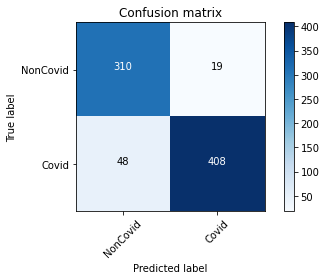

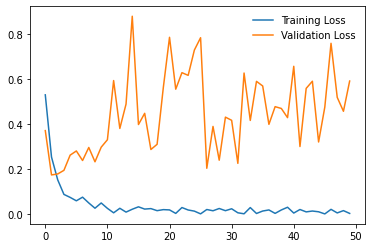

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096,2)
run_model(model, name = dir+"/vgg16-v2",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.9567 Acc: 0.8331
val Loss: 0.2290 Acc: 0.8959

Epoch 2/50
----------
train Loss: 0.1268 Acc: 0.9540
val Loss: 0.3369 Acc: 0.8904

Epoch 3/50
----------
train Loss: 0.0844 Acc: 0.9717
val Loss: 0.2867 Acc: 0.9123

Epoch 4/50
----------
train Loss: 0.0639 Acc: 0.9771
val Loss: 0.2304 Acc: 0.9233

Epoch 5/50
----------
train Loss: 0.0421 Acc: 0.9865
val Loss: 0.1300 Acc: 0.9479

Epoch 6/50
----------
train Loss: 0.0393 Acc: 0.9863
val Loss: 0.3233 Acc: 0.9205

Epoch 7/50
----------
train Loss: 0.0382 Acc: 0.9875
val Loss: 0.3539 Acc: 0.8932

Epoch 8/50
----------
train Loss: 0.0572 Acc: 0.9791
val Loss: 0.2735 Acc: 0.9151

Epoch 9/50
----------
train Loss: 0.0264 Acc: 0.9924
val Loss: 0.3424 Acc: 0.9260

Epoch 10/50
----------
train Loss: 0.0122 Acc: 0.9966
val Loss: 0.3871 Acc: 0.9397

Epoch 11/50
----------
train Loss: 0.0260 Acc: 0.9910
val Loss: 0.5645 Acc: 0.9288

Epoch 12/50
----------
train Loss: 0.0482 Acc: 0.9837
val Loss: 0.44

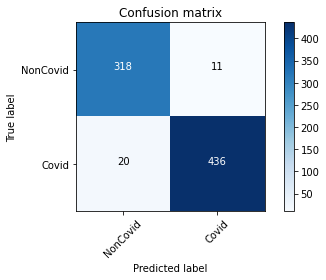

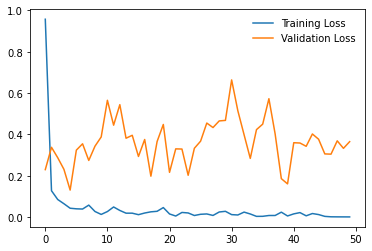

In [ ]:
model = models.resnet101(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet101-v2",  freeze = True)

Using GPU: True
Epoch 1/50
----------
train Loss: 1.0257 Acc: 0.8170
val Loss: 0.2816 Acc: 0.9315

Epoch 2/50
----------
train Loss: 0.1135 Acc: 0.9590
val Loss: 0.2901 Acc: 0.9123

Epoch 3/50
----------
train Loss: 0.0778 Acc: 0.9721
val Loss: 0.1761 Acc: 0.9151

Epoch 4/50
----------
train Loss: 0.0668 Acc: 0.9807
val Loss: 0.2900 Acc: 0.9288

Epoch 5/50
----------
train Loss: 0.0554 Acc: 0.9801
val Loss: 0.4429 Acc: 0.8822

Epoch 6/50
----------
train Loss: 0.0374 Acc: 0.9881
val Loss: 0.2729 Acc: 0.9178

Epoch 7/50
----------
train Loss: 0.0494 Acc: 0.9817
val Loss: 0.2204 Acc: 0.9151

Epoch 8/50
----------
train Loss: 0.0345 Acc: 0.9881
val Loss: 0.3979 Acc: 0.9123

Epoch 9/50
----------
train Loss: 0.0145 Acc: 0.9954
val Loss: 0.5094 Acc: 0.8904

Epoch 10/50
----------
train Loss: 0.0187 Acc: 0.9936
val Loss: 0.3909 Acc: 0.9014

Epoch 11/50
----------
train Loss: 0.0352 Acc: 0.9881
val Loss: 0.2690 Acc: 0.9151

Epoch 12/50
----------
train Loss: 0.0446 Acc: 0.9853
val Loss: 0.286

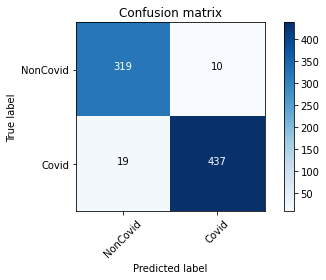

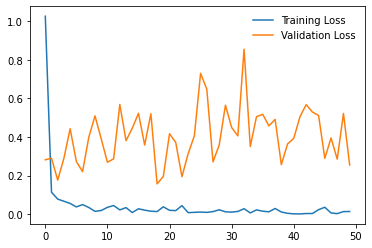

In [ ]:
model = models.resnet152(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet152-v2",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.0293 Acc: 0.8237
val Loss: 0.2786 Acc: 0.9151

Epoch 2/50
----------
train Loss: 0.1172 Acc: 0.9554
val Loss: 0.2303 Acc: 0.9151

Epoch 3/50
----------
train Loss: 0.0866 Acc: 0.9673
val Loss: 0.5635 Acc: 0.8356

Epoch 4/50
----------
train Loss: 0.0656 Acc: 0.9763
val Loss: 0.2727 Acc: 0.9178

Epoch 5/50
----------
train Loss: 0.0349 Acc: 0.9886
val Loss: 0.2707 Acc: 0.9151

Epoch 6/50
----------
train Loss: 0.0501 Acc: 0.9825
val Loss: 0.2328 Acc: 0.9260

Epoch 7/50
----------
train Loss: 0.0142 Acc: 0.9954
val Loss: 0.3869 Acc: 0.9151

Epoch 8/50
----------
train Loss: 0.0308 Acc: 0.9882
val Loss: 0.2394 Acc: 0.9370

Epoch 9/50
----------
train Loss: 0.0517 Acc: 0.9813
val Loss: 0.5036 Acc: 0.9315

Epoch 10/50
----------
train Loss: 0.0192 Acc: 0.9932
val Loss: 0.3963 Acc: 0.9041

Epoch 11/50
----------
train Loss: 0.0162 Acc: 0.9932
val Loss: 0.4705 Acc: 0.9397

Epoch 12/50
----------
train Loss: 0.0348 Acc: 0.9879
val Loss: 0.52

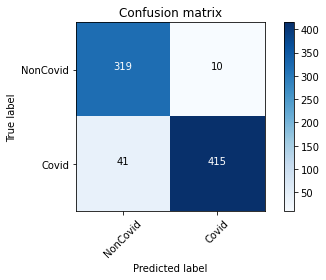

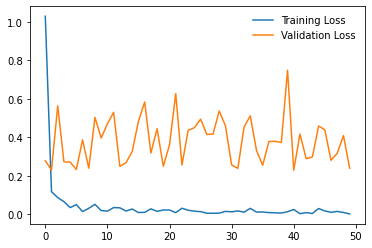

In [ ]:
model = models.resnet50(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet50-v2",  freeze = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 1.6562 Acc: 0.7574
val Loss: 0.2594 Acc: 0.9151

Epoch 2/50
----------
train Loss: 0.1490 Acc: 0.9506
val Loss: 0.5355 Acc: 0.8247

Epoch 3/50
----------
train Loss: 0.0827 Acc: 0.9711
val Loss: 0.5062 Acc: 0.8959

Epoch 4/50
----------
train Loss: 0.0532 Acc: 0.9843
val Loss: 0.2924 Acc: 0.9151

Epoch 5/50
----------
train Loss: 0.0555 Acc: 0.9803
val Loss: 0.2882 Acc: 0.9205

Epoch 6/50
----------
train Loss: 0.0470 Acc: 0.9821
val Loss: 0.3823 Acc: 0.8959

Epoch 7/50
----------
train Loss: 0.0497 Acc: 0.9811
val Loss: 0.4425 Acc: 0.9068

Epoch 8/50
----------
train Loss: 0.0351 Acc: 0.9879
val Loss: 0.5694 Acc: 0.8356

Epoch 9/50
----------
train Loss: 0.0256 Acc: 0.9912
val Loss: 0.2872 Acc: 0.8932

Epoch 10/50
----------
train Loss: 0.0220 Acc: 0.9942
val Loss: 0.2554 Acc: 0.9288

Epoch 11/50
----------
train Loss: 0.0310 Acc: 0.9900
val Loss: 0.4800 Acc: 0.8877

Epoch 12/50
----------
train Loss: 0.0416 Acc: 0.9859
val Loss: 0.45

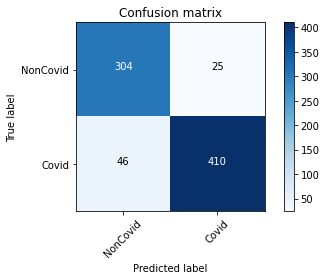

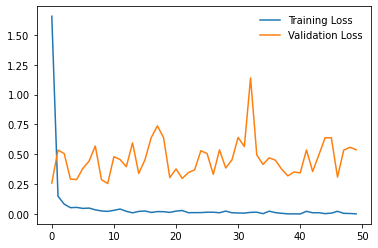

In [17]:
model = models.resnet18(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/resnet18-v2",  freeze = True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Using GPU: True
Epoch 1/50
----------
train Loss: 0.3286 Acc: 0.8528
val Loss: 0.3276 Acc: 0.8548

Epoch 2/50
----------
train Loss: 0.1082 Acc: 0.9624
val Loss: 0.2887 Acc: 0.8986

Epoch 3/50
----------
train Loss: 0.0637 Acc: 0.9775
val Loss: 0.4385 Acc: 0.8767

Epoch 4/50
----------
train Loss: 0.0357 Acc: 0.9879
val Loss: 0.2337 Acc: 0.8959

Epoch 5/50
----------
train Loss: 0.0290 Acc: 0.9914
val Loss: 0.1242 Acc: 0.9507

Epoch 6/50
----------
train Loss: 0.0196 Acc: 0.9944
val Loss: 0.2480 Acc: 0.9178

Epoch 7/50
----------
train Loss: 0.0292 Acc: 0.9904
val Loss: 0.2552 Acc: 0.9151

Epoch 8/50
----------
train Loss: 0.0196 Acc: 0.9940
val Loss: 0.2725 Acc: 0.9178

Epoch 9/50
----------
train Loss: 0.0210 Acc: 0.9926
val Loss: 0.8709 Acc: 0.7973

Epoch 10/50
----------
train Loss: 0.0315 Acc: 0.9873
val Loss: 0.2292 Acc: 0.9260

Epoch 11/50
----------
train Loss: 0.0218 Acc: 0.9930
val Loss: 0.2467 Acc: 0.9178

Epoch 12/50
----------
train Loss: 0.0053 Acc: 0.9992
val Loss: 0.28

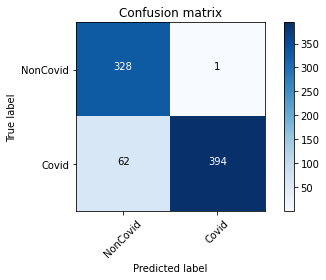

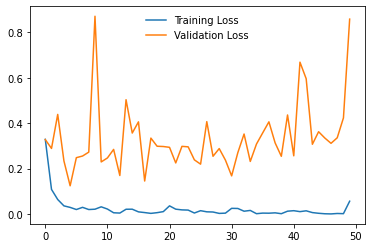

In [18]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 2)
run_model(model, name = dir+"/densenet121-v2",  freeze = True)

In [19]:
get_ipython().system('pip install --upgrade efficientnet-pytorch')

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=fc7167cdedd512cb0cba18727c05c7c27ed39cd64f09dea9afbfd38fbcdc01a9
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [20]:
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

In [21]:
from efficientnet_pytorch import EfficientNet

class EfficientNet_b0(nn.Module):
    def __init__(self):
        super(EfficientNet_b0, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
        
        self.layer10 = nn.Sequential(
            nn.BatchNorm1d(1280),
            nn.Dropout(0.8)
        )
        self.layer11a = nn.Sequential(
            nn.Linear(1280, 2048),
            nn.BatchNorm1d(2048),
            Swish(),
            nn.Dropout(0.8)
        )
        self.layer11b = nn.Sequential(
            nn.Linear(2048 , 1024),
            nn.BatchNorm1d(1024), 
            Swish(),
            nn.Dropout(0.8)
        )
        self.layer12 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.BatchNorm1d(512),
            Swish()
        )
        self.layer13 = nn.Sequential(
            nn.Linear(512 , 2),
            nn.Softmax()
        )
        
    def forward(self, inputs):
        x = self.model.extract_features(inputs)

        # Pooling and final linear layer
        x = self.model._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.model._dropout(x)
        x = self.layer10(x)
        x = self.layer11a(x)
        x = self.layer11b(x)
        x = self.layer12(x)
        x = self.layer13(x)
        return x

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
Using GPU: True
Epoch 1/50
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 0.6860 Acc: 0.5511
val Loss: 0.5993 Acc: 0.8027

Epoch 2/50
----------
train Loss: 0.5397 Acc: 0.7712
val Loss: 0.4555 Acc: 0.8575

Epoch 3/50
----------
train Loss: 0.4282 Acc: 0.8867
val Loss: 0.4553 Acc: 0.8438

Epoch 4/50
----------
train Loss: 0.3904 Acc: 0.9257
val Loss: 0.4722 Acc: 0.8356

Epoch 5/50
----------
train Loss: 0.3682 Acc: 0.9480
val Loss: 0.4330 Acc: 0.8740

Epoch 6/50
----------
train Loss: 0.3610 Acc: 0.9540
val Loss: 0.4003 Acc: 0.9178

Epoch 7/50
----------
train Loss: 0.3538 Acc: 0.9596
val Loss: 0.4010 Acc: 0.9096

Epoch 8/50
----------
train Loss: 0.3513 Acc: 0.9610
val Loss: 0.4089 Acc: 0.9041

Epoch 9/50
----------
train Loss: 0.3465 Acc: 0.9665
val Loss: 0.3750 Acc: 0.9370

Epoch 10/50
----------
train Loss: 0.3461 Acc: 0.9655
val Loss: 0.3762 Acc: 0.9342

Epoch 11/50
----------
train Loss: 0.3442 Acc: 0.9701
val Loss: 0.4010 Acc: 0.9123

Epoch 12/50
----------
train Loss: 0.3347 Acc: 0.9787
val Loss: 0.3941 Acc: 0.9151

Epoch 13/50
----------


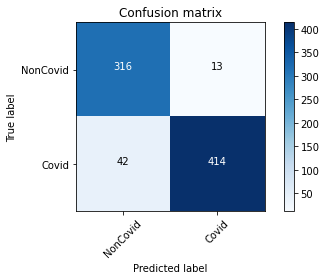

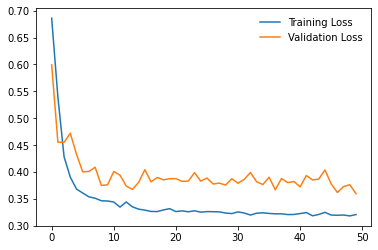

In [22]:
### efficientCovidNet
model = EfficientNet_b0()
run_model(model, name = dir+"/EfficientNet_b0-v2",  freeze = True)

<h1>Plot All Losses</h1>

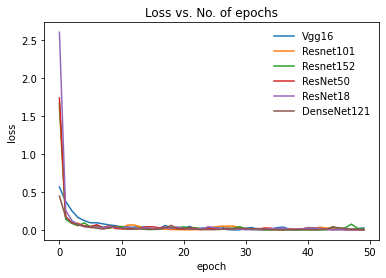

In [ ]:
def plot_all_losses(losses, t):
    plt.figure()
    models = ['Vgg16', 'Resnet101','Resnet152', 'ResNet50', 'ResNet18', 'DenseNet121']

    for i, val in enumerate(losses):
        plt.plot(val, label=models[i])
        plt.legend(frameon=False)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')   
    plt.savefig("plots/sagan/kaggle/"+dir+"/"+t+"_losses_resnet.png")
    plt.show()
        
plot_all_losses(train_losses_all, t="training")

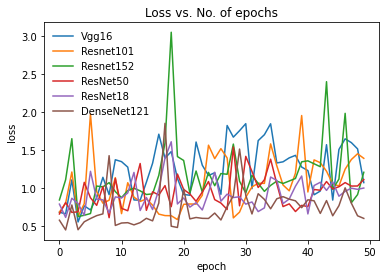

In [ ]:
plot_all_losses(test_losses_all, t="testing")

<h1>Testing trained models on Sars_Cov_2 on CT_COVID dataset test set</h1>

In [ ]:
#densenet121_epoch_50.pth
#resnet18_epoch_50.pth
#resnet50_epoch_50.pth
#resnet101_epoch_50.pth
#resnet152_epoch_50.pth
#vgg16_epoch_50.pth

test_transform = transforms.Compose([
                                 transforms.Resize((224, 224)),                                       
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

images_covid = "revised-kaggle-validation/"
test_datasets = datasets.ImageFolder(os.path.join(images_covid, 'test'),transform= test_transform)

test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
print(len(test_loader))

25


Testing Accuracy: 0.036
Testing Accuracy: 0.071
Testing Accuracy: 0.102
Testing Accuracy: 0.140
Testing Accuracy: 0.176
Testing Accuracy: 0.214
Testing Accuracy: 0.248
Testing Accuracy: 0.280
Testing Accuracy: 0.312
Testing Accuracy: 0.347
Testing Accuracy: 0.377
Testing Accuracy: 0.416
Testing Accuracy: 0.451
Testing Accuracy: 0.488
Testing Accuracy: 0.524
Testing Accuracy: 0.559
Testing Accuracy: 0.592
Testing Accuracy: 0.629
Testing Accuracy: 0.666
Testing Accuracy: 0.704
Testing Accuracy: 0.739
Testing Accuracy: 0.772
Testing Accuracy: 0.808
Testing Accuracy: 0.842
Testing Accuracy: 0.878
[[321   8]
 [ 88 368]]
[97.56838906 80.70175439]
Accuracy score: 0.8777070063694268
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       329
           1       0.98      0.81      0.88       456

    accuracy                           0.88       785
   macro avg       0.88      0.89      0.88       785
weighted avg       0.90      0.88      0.88 

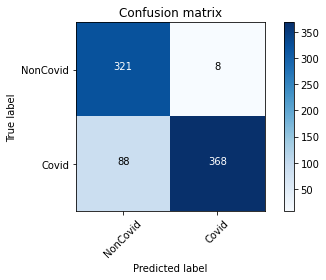

In [ ]:
loaded_model = torch.load("model_backup/sagan/kaggle/epochs=20_lr=0.0002_batch_size=32_gen=500/densenet121_epoch_50.pth")
name = "densenet121"
test_on_another_data(loaded_model, test_loader, device, name, 50)

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/vgg16_epoch_50.pth")
name = "vgg16_epoch_50_on_kaggle_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.026
Testing Accuracy: 0.047
Testing Accuracy: 0.072
Testing Accuracy: 0.101


Testing Accuracy: 0.025
Testing Accuracy: 0.043
Testing Accuracy: 0.068
Testing Accuracy: 0.089
Testing Accuracy: 0.116
Testing Accuracy: 0.139
Testing Accuracy: 0.157
[[56 42]
 [45 60]]
[57.14285714 57.14285714]
Accuracy score: 0.5714285714285714
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        98
           1       0.59      0.57      0.58       105

    accuracy                           0.57       203
   macro avg       0.57      0.57      0.57       203
weighted avg       0.57      0.57      0.57       203

Confusion matrix, without normalization
[[56 42]
 [45 60]]


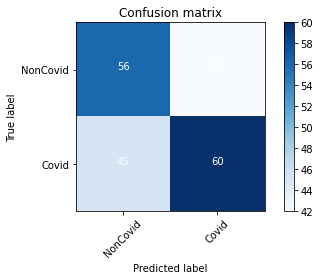

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet152_epoch_50.pth")
name = "resnet152_epoch_50_on_kaggle_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.016
Testing Accuracy: 0.032
Testing Accuracy: 0.059
Testing Accuracy: 0.079
Testing Accuracy: 0.100
Testing Accuracy: 0.120
Testing Accuracy: 0.145
[[30 68]
 [32 73]]
[30.6122449  69.52380952]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.48      0.31      0.38        98
           1       0.52      0.70      0.59       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.48       203
weighted avg       0.50      0.51      0.49       203

Confusion matrix, without normalization
[[30 68]
 [32 73]]


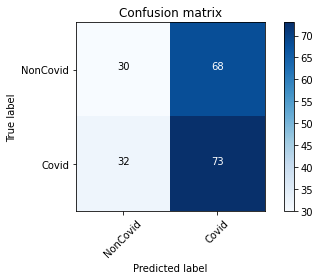

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet101_epoch_50.pth")
name = "resnet101_epoch_50_on_kaggle_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.024
Testing Accuracy: 0.043
Testing Accuracy: 0.060
Testing Accuracy: 0.083
Testing Accuracy: 0.106
Testing Accuracy: 0.121
Testing Accuracy: 0.143
[[37 61]
 [39 66]]
[37.75510204 62.85714286]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.38      0.43        98
           1       0.52      0.63      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[37 61]
 [39 66]]


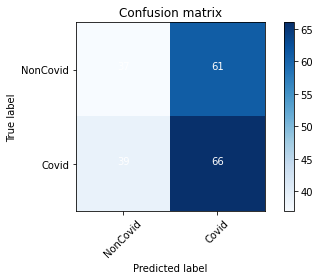

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet50_epoch_50.pth")
name = "resnet50_epoch_50_on_kaggle_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.023
Testing Accuracy: 0.044
Testing Accuracy: 0.061
Testing Accuracy: 0.080
Testing Accuracy: 0.101
Testing Accuracy: 0.121
Testing Accuracy: 0.143
[[36 62]
 [38 67]]
[36.73469388 63.80952381]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.37      0.42        98
           1       0.52      0.64      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[36 62]
 [38 67]]


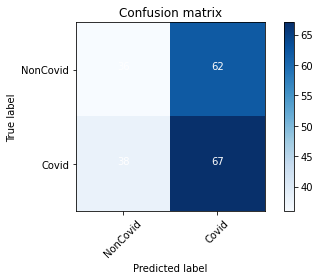

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
name = "resnet18_epoch_50_on_kaggle_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.023
Testing Accuracy: 0.040
Testing Accuracy: 0.064
Testing Accuracy: 0.087
Testing Accuracy: 0.105
Testing Accuracy: 0.124
Testing Accuracy: 0.138
[[36 62]
 [38 67]]
[36.73469388 63.80952381]
Accuracy score: 0.5073891625615764
              precision    recall  f1-score   support

           0       0.49      0.37      0.42        98
           1       0.52      0.64      0.57       105

    accuracy                           0.51       203
   macro avg       0.50      0.50      0.50       203
weighted avg       0.50      0.51      0.50       203

Confusion matrix, without normalization
[[36 62]
 [38 67]]


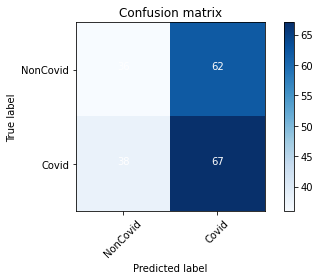

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/resnet18_epoch_50.pth")
name = "resnet18_epoch_50_on_kaggle_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)

Testing Accuracy: 0.038
Testing Accuracy: 0.078
Testing Accuracy: 0.115
Testing Accuracy: 0.150
Testing Accuracy: 0.186
Testing Accuracy: 0.225
Testing Accuracy: 0.262
Testing Accuracy: 0.303
Testing Accuracy: 0.339
Testing Accuracy: 0.376
Testing Accuracy: 0.414
Testing Accuracy: 0.452
Testing Accuracy: 0.491
Testing Accuracy: 0.529
Testing Accuracy: 0.569
Testing Accuracy: 0.604
Testing Accuracy: 0.642
Testing Accuracy: 0.675
Testing Accuracy: 0.711
Testing Accuracy: 0.748
Testing Accuracy: 0.785
Testing Accuracy: 0.820
Testing Accuracy: 0.855
Testing Accuracy: 0.891
Testing Accuracy: 0.922
[[323   6]
 [ 53 403]]
[98.17629179 88.37719298]
Accuracy score: 0.9248407643312102
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       329
           1       0.99      0.88      0.93       456

    accuracy                           0.92       785
   macro avg       0.92      0.93      0.92       785
weighted avg       0.93      0.92      0.93 

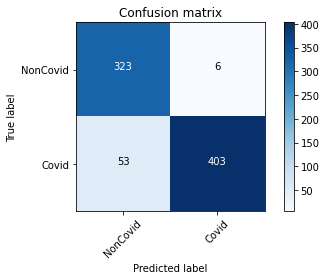

In [ ]:
loaded_model = torch.load("model_backup/transfer_learning_results_kaggle/densenet121_epoch_50.pth")
name = "densenet121_epoch_50_epoch_50_on_kaggle_trained_on_kaggle"
test_on_another_data(loaded_model, test_loader, device, name, 50)